<a href="https://colab.research.google.com/github/mveerara/Teleradiology/blob/main/Test_and_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from os import listdir
import skimage.transform
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import sys
import os
import pickle
from collections import defaultdict
from collections import OrderedDict
import keras

import skimage
from skimage.io import *
from skimage.transform import *

import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from scipy.ndimage import binary_dilation
import matplotlib.patches as patches

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/MyDrive')

Mounted at /MyDrive


In [ ]:
test_txt_path = '/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/test_list.txt'
img_folder_path = '/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images'

In [ ]:
with open(test_txt_path, "r") as f:
    test_list = [i.strip() for i in f.readlines()] 
    print(test_list[0:100])

['00000003_000.png', '00000003_001.png', '00000003_002.png', '00000003_003.png', '00000003_004.png', '00000003_005.png', '00000003_006.png', '00000003_007.png', '00000013_000.png', '00000013_001.png', '00000013_002.png', '00000013_003.png', '00000013_004.png', '00000013_005.png', '00000013_006.png', '00000013_007.png', '00000013_008.png', '00000013_009.png', '00000013_010.png', '00000013_011.png', '00000013_012.png', '00000013_013.png', '00000013_014.png', '00000013_015.png', '00000013_016.png', '00000013_017.png', '00000013_018.png', '00000013_019.png', '00000013_020.png', '00000013_021.png', '00000013_022.png', '00000013_023.png', '00000013_024.png', '00000013_025.png', '00000013_026.png', '00000013_027.png', '00000013_028.png', '00000013_029.png', '00000013_030.png', '00000013_031.png', '00000013_032.png', '00000013_033.png', '00000013_034.png', '00000013_035.png', '00000013_036.png', '00000013_037.png', '00000013_038.png', '00000013_039.png', '00000013_040.png', '00000013_041.png',

In [ ]:
print("number of test examples:",len(test_list))

number of test examples: 25596


In [ ]:
import imageio
test_X = []
print("load and transform image")
for i in range(len(test_list[0:2000])):
    image_path = os.path.join(img_folder_path, test_list[i])
    try:
      img = imageio.imread(image_path) #img = scipy.misc.imread(image_path)
    except OSError:
       pass 
    if img.shape != (1024,1024):
        img = img[:,:,0]
    img_resized = skimage.transform.resize(img,(256,256))
    test_X.append((np.array(img_resized)).reshape(256,256,1))
    #if i % 100==0:
        #print(i)
test_X = np.array(test_X)
print(test_X[0:100])

load and transform image
[[[[0.2       ]
   [0.11176471]
   [0.06666667]
   ...
   [0.04705882]
   [0.05294118]
   [0.04313725]]

  [[0.19607843]
   [0.10980392]
   [0.0627451 ]
   ...
   [0.04705882]
   [0.05098039]
   [0.04313725]]

  [[0.19411765]
   [0.10588235]
   [0.06176471]
   ...
   [0.04705882]
   [0.05098039]
   [0.04313725]]

  ...

  [[0.04117647]
   [0.03823529]
   [0.03431373]
   ...
   [0.39607843]
   [0.66078431]
   [0.77745098]]

  [[0.09607843]
   [0.09313725]
   [0.08627451]
   ...
   [0.40588235]
   [0.6745098 ]
   [0.78921569]]

  [[0.17647059]
   [0.17352941]
   [0.16666667]
   ...
   [0.41764706]
   [0.68921569]
   [0.79803922]]]


 [[[0.14705882]
   [0.11764706]
   [0.09411765]
   ...
   [0.49607843]
   [0.4872549 ]
   [0.46764706]]

  [[0.15098039]
   [0.12156863]
   [0.09705882]
   ...
   [0.44803922]
   [0.42941176]
   [0.40980392]]

  [[0.14313725]
   [0.11568627]
   [0.09019608]
   ...
   [0.34901961]
   [0.34117647]
   [0.32941176]]

  ...

  [[0.41372549

In [ ]:
# model archi
# construct model
class DenseNet121(nn.Module):
	"""Model modified.
	The architecture of our model is the same as standard DenseNet121
	except the classifier layer which has an additional sigmoid function.
	"""
	def __init__(self, out_size):
		super(DenseNet121, self).__init__()
		self.densenet121 = torchvision.models.densenet121(pretrained=True)
		num_ftrs = self.densenet121.classifier.in_features
		self.densenet121.classifier = nn.Sequential(
		    nn.Linear(num_ftrs, out_size),
		    nn.Sigmoid()
		)

	def forward(self, x):
		x = self.densenet121(x)
		return x

In [ ]:
model = DenseNet121(8).cuda() # eight diseases to be classified, hence final layer count 8
model = torch.nn.DataParallel(model) # do it in parallel


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

model.load_state_dict(torch.load("/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/output/DenseNet121_aug4_pretrain_noWeight_10_0.5324519643951093.pkl"))
print("model loaded")

model loaded


In [ ]:
print(model)

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Dens

In [ ]:

# build test dataset
class ChestXrayDataSet_plot(Dataset):
	def __init__(self, input_X = test_X, transform=None):
		self.X = np.uint8(test_X*255)
		self.transform = transform

	def __getitem__(self, index):
		"""
		Args:
		    index: the index of item 
		Returns:
		    image 
		"""
		current_X = np.tile(self.X[index],3)
		image = self.transform(current_X)
		return image
	def __len__(self):
		return len(self.X)

test_dataset = ChestXrayDataSet_plot(input_X = test_X,transform=transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                        ]))

In [ ]:

thresholds = np.load("/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/thresholds.npy")
print("activate threshold",thresholds)

activate threshold [0.19362465 0.07700258 0.3401143  0.39875817 0.08521137 0.14014415
 0.02213187 0.08226113]


In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 27.7MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=48f01e06afda796fbcbde7a2ac8960890979219063065503f93f9aa9abba43c7
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
from lime import lime_image
from tensorflow.keras import Model
import tensorflow as tf, numpy as np, cv2.cv2 as cv2

# deprecated GradCAM function
# def generate_heatmap(model, input_image):
#     grads = visualize_cam(model, layer_idx=-1, filter_indices=None, seed_input=input_image, backprop_modifier=None,
#                           grad_modifier=None, penultimate_layer_idx=None)
#     jet_heatmap = np.uint8(cm.jet(grads)[:, :, :, 0] * 255)
#     return jet_heatmap


def generate_explanation(model, input_image):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image=input_image, classifier_fn=model.predict, hide_color=0,
                                             num_samples=1000, random_seed=18)
    temp, mask = explanation.get_image_and_mask(label=explanation.top_labels[0], positive_only=True, num_features=5,
                                                hide_rest=False)
    return temp, mask


class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8, normalize=True):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.input], outputs=[self.model.get_layer(self.layerName).output,
                                                              self.model.output])
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            inputs = np.expand_dims(inputs, axis=0)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        # if gradients are too small (GradCAM is zero everywhere)
        # equal to changing the value of 'eps' func arg
        grads = grads / (grads.numpy().max() - grads.numpy().min())
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        h, w = image.shape[:2]
        heatmap = cv2.resize(cam.numpy(), (w, h))
        print('avg heatmap value:', np.mean(heatmap))
        print('max heatmap value:', np.max(heatmap))
        # ignore certain values lower than a threshold to get sharper heatmaps
        # heatmap[np.where(heatmap < 1)] = 0
        if normalize:
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255)
        return heatmap.astype("uint8")

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        # if the input image is grey-scale, convert it to 3-dim
        if len(image.shape) == 2 or image.shape[-1] != 3:
            image = cv2.cvtColor(src=image, code=cv2.COLOR_GRAY2RGB)
        # if image px values are in [0, 1], upscale to [0, 255]
        if np.max(image) <= 1.0:
            image = image * 255.0
        output = cv2.addWeighted(image.astype('uint8'), alpha, heatmap, 1 - alpha, 0)
        return output

In [ ]:
!python3 "/MyDrive/MyDrive/Teleradiology/Example_Program/example1/visualization_tools.py"

2021-06-25 10:23:46.092100: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
import matplotlib as plt
#from visualization_tools import GradCAM
IMG_ID = np.random.randint(low=0, high=len(test_dataset), size=None)
print('image index:', IMG_ID)
test_img = test_dataset[IMG_ID]
#temp_img = (test_dataset[IMG_ID] * 255.).astype('uint8')

#fig1 = plt.figure.Figure(num=7, figsize=(21, 3))

cam = GradCAM(model=model, classIdx=0)
heatmap = cam.compute_heatmap(image=test_img, normalize=True)
overlaid_heatmap = cam.overlay_heatmap(heatmap=heatmap, image=temp_img, alpha=0.8, 
                                       colormap=cv2.COLORMAP_HSV)
print(overlaid_heatmap)

image index: 1314


AttributeError: ignored

In [ ]:
print("generate heatmap ..........")
# ======= Grad CAM Function =========
class PropagationBase(object):

    def __init__(self, model, cuda=False):
        self.model = model
        self.model.eval()
        if cuda:
            self.model.cuda()
        self.cuda = cuda
        self.all_fmaps = OrderedDict()
        self.all_grads = OrderedDict()
        self._set_hook_func()
        self.image = None

    def _set_hook_func(self):
        raise NotImplementedError

    def _encode_one_hot(self, idx):
        one_hot = torch.FloatTensor(1, self.preds.size()[-1]).zero_()
        one_hot[0][idx] = 1.0
        return one_hot.cuda() if self.cuda else one_hot

    def forward(self, image):
        self.image = image
        self.preds = self.model.forward(self.image)
#         self.probs = F.softmax(self.preds)[0]
#         self.prob, self.idx = self.preds[0].data.sort(0, True)
        return self.preds.cpu().data.numpy()

    def backward(self, idx):
        self.model.zero_grad()
        one_hot = self._encode_one_hot(idx)
        self.preds.backward(gradient=one_hot, retain_graph=True)


generate heatmap ..........


In [ ]:
class GradCAM(PropagationBase):

    def _set_hook_func(self):

        def func_f(module, input, output):
            self.all_fmaps[id(module)] = output.data.cpu()

        def func_b(module, grad_in, grad_out):
            self.all_grads[id(module)] = grad_out[0].cpu()

        for module in self.model.named_modules():
            module[1].register_forward_hook(func_f)
            module[1].register_backward_hook(func_b)

    def _find(self, outputs, target_layer):
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:
                        return value
        raise ValueError('Invalid layer name: {}'.format(target_layer))

    def _normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.data

    def _compute_grad_weights(self, grads):
        grads = self._normalize(grads)
        self.map_size = grads.size()[2:]
        return nn.AvgPool2d(self.map_size)(grads)

    def generate(self, target_layer):
        fmaps = self._find(self.all_fmaps, target_layer)
        grads = self._find(self.all_grads, target_layer)
        weights = self._compute_grad_weights(grads)
        gcam = torch.FloatTensor(self.map_size).zero_()
        for fmap, weight in zip(fmaps[0], weights[0]):
            gcam += fmap * weight.data
        
        gcam = F.relu(Variable(gcam))

        gcam = gcam.data.cpu().numpy()
        gcam -= gcam.min()
        gcam /= gcam.max()
        gcam = cv2.resize(gcam, (self.image.size(3), self.image.size(2)))

        return gcam

    def save(self, filename, gcam, raw_image):
        gcam = cv2.applyColorMap(np.float32(gcam),cv2.COLORMAP_JET) #(np.uint8(gcam * 255.0), cv2.COLORMAP_JET)
        gcam = gcam.astype(np.float) + raw_image.astype(np.float)
        gcam = gcam / gcam.max() * 255.0
        cv2.imwrite(filename, np.uint8(gcam))

In [ ]:
# ======== Create heatmap ===========

heatmap_output = []
image_id = []
output_class = []

gcam = GradCAM(model=model, cuda=True)
for index in range(len(test_dataset)):
    input_img = Variable((test_dataset[index]).unsqueeze(0).cuda(), requires_grad=True)
    probs = gcam.forward(input_img)

    activate_classes = np.where((probs > thresholds)[0]==True)[0] # get the activated class
    for activate_class in activate_classes:
        gcam.backward(idx=activate_class)
        output = gcam.generate(target_layer="module.densenet121.features.denseblock4.denselayer16.conv2")
        #### this output is heatmap ####
        if np.sum(np.isnan(output)) > 0:
            print("fxxx nan")
        heatmap_output.append(output)
        image_id.append(index)
        output_class.append(activate_class)
    print("test ",str(index)," finished")

print("heatmap output done")
print("total number of heatmap: ",len(heatmap_output))


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:949: UserWarning: Using non-full backward hooks on a Module that does not take as input a single 

test  0  finished
test  1  finished
test  2  finished
test  3  finished
test  4  finished
test  5  finished
test  6  finished
test  7  finished
test  8  finished
test  9  finished
test  10  finished
test  11  finished
test  12  finished
test  13  finished
test  14  finished
test  15  finished
test  16  finished
test  17  finished
test  18  finished
test  19  finished
test  20  finished
test  21  finished
test  22  finished
test  23  finished
test  24  finished
test  25  finished
test  26  finished
test  27  finished
test  28  finished
test  29  finished
test  30  finished
test  31  finished
test  32  finished
test  33  finished
test  34  finished
test  35  finished
test  36  finished
test  37  finished
test  38  finished
test  39  finished
test  40  finished
test  41  finished
test  42  finished
test  43  finished
test  44  finished
test  45  finished
test  46  finished
test  47  finished
test  48  finished
test  49  finished
test  50  finished
test  51  finished
test  52  finished
tes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


fxxx nan
test  230  finished
test  231  finished
test  232  finished
test  233  finished
test  234  finished
test  235  finished
test  236  finished
test  237  finished
test  238  finished
test  239  finished
test  240  finished
test  241  finished
test  242  finished
test  243  finished
test  244  finished
test  245  finished
test  246  finished
test  247  finished
test  248  finished
test  249  finished
test  250  finished
test  251  finished
test  252  finished
test  253  finished
test  254  finished
test  255  finished
test  256  finished
test  257  finished
test  258  finished
test  259  finished
test  260  finished
test  261  finished
test  262  finished
test  263  finished
test  264  finished
test  265  finished
test  266  finished
test  267  finished
test  268  finished
test  269  finished
test  270  finished
test  271  finished
test  272  finished
test  273  finished
test  274  finished
test  275  finished
test  276  finished
test  277  finished
test  278  finished
test  279  

In [ ]:
heatmap_output[1000]

array([[0.01683396, 0.01683396, 0.01683396, ..., 0.        , 0.        ,
        0.        ],
       [0.01683396, 0.01683396, 0.01683396, ..., 0.        , 0.        ,
        0.        ],
       [0.01683396, 0.01683396, 0.01683396, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
print(len(heatmap_output))

3206


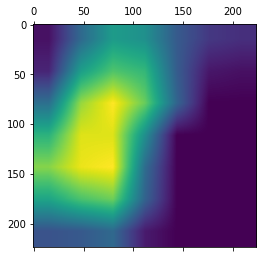

In [ ]:
import matplotlib.pyplot as plot
plot.matshow(heatmap_output[100])

In [ ]:
#from numpy import save
heatmap_path = '/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/output/valid_heatmap'
for i in range(len(heatmap_output)):
  #heatmap_path = os.path.join(heatmap_path,image_path )
  heatmap_file = test_list[i].rsplit('.', 1)[0] #str.rsplit(test_list[i])
  print(heatmap_file)
  file_name = os.path.join(heatmap_path, heatmap_file + '.npy')
  print(file_name)
  with open(file_name ,'w') as f:
   gcam.save(file_name,heatmap_output[i],test_list[i])



00000003_000
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/output/valid_heatmap/00000003_000.npy


error: ignored

In [ ]:
# ======= Plot bounding box =========
img_width, img_height = 224, 224
img_width_exp, img_height_exp = 1024, 1024

crop_del = 16
rescale_factor = 4

class_index = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
avg_size = np.array([[411.8, 512.5, 219.0, 139.1], [348.5, 392.3, 479.8, 381.1],
                     [396.5, 415.8, 221.6, 318.0], [394.5, 389.1, 294.0, 297.4],
                     [434.3, 366.7, 168.7, 189.8], [502.4, 458.7, 71.9, 70.4],
                     [378.7, 416.7, 276.5, 304.5], [369.3, 209.4, 198.9, 246.0]])


prediction_dict = {}
print(len(test_list[0:2000]))
for i in range(len(test_list[0:2000])):
    prediction_dict[i] = []


    

2000


In [ ]:
for img_id, k, npy in zip(image_id, output_class, heatmap_output):
    
    data = npy
    img_fname = test_list[img_id]
    print(img_fname)
    print(data)
    print(avg_size[k][0])

    # output avgerge
    prediction_sent = '%s %.1f %.1f %.1f %.1f' % (class_index[k], avg_size[k][0], avg_size[k][1], avg_size[k][2], avg_size[k][3])
    prediction_dict[img_id].append(prediction_sent)
    print(prediction_dict)

    if np.isnan(data).any():
        continue

    w_k, h_k = (avg_size[k][2:4] * (256 / 1024)).astype(np.int)

00000003_000.png
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


NameError: ignored

In [ ]:
 # Find local maxima
neighborhood_size = 100
threshold = .1
    
data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0
for _ in range(5):
    maxima = binary_dilation(maxima)
    
labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
xy = np.array(ndimage.center_of_mass(data, labeled, range(1, num_objects+1)))
        
for pt in xy:
    if data[int(pt[0]), int(pt[1])] > np.max(data)*.9:
        upper = int(max(pt[0]-(h_k/2), 0.))
        left = int(max(pt[1]-(w_k/2), 0.))

        right = int(min(left+w_k, img_width))
        lower = int(min(upper+h_k, img_height))
            
        prediction_sent = '%s %.1f %.1f %.1f %.1f' % (class_index[k], (left+crop_del)*rescale_factor, \
                                                                          (upper+crop_del)*rescale_factor, \
                                                                          (right-left)*rescale_factor, \
                                                                          (lower-upper)*rescale_factor)
            
        prediction_dict[img_id].append(prediction_sent)


In [ ]:
print(prediction_dict)

{0: ['Nodule 502.4 458.7 71.9 70.4'], 1: ['Nodule 502.4 458.7 71.9 70.4'], 2: ['Nodule 502.4 458.7 71.9 70.4', 'Pneumothorax 369.3 209.4 198.9 246.0'], 3: ['Infiltration 394.5 389.1 294.0 297.4'], 4: [], 5: [], 6: [], 7: ['Infiltration 394.5 389.1 294.0 297.4'], 8: ['Cardiomegaly 348.5 392.3 479.8 381.1'], 9: ['Cardiomegaly 348.5 392.3 479.8 381.1'], 10: ['Cardiomegaly 348.5 392.3 479.8 381.1', 'Infiltration 394.5 389.1 294.0 297.4'], 11: ['Pneumothorax 369.3 209.4 198.9 246.0'], 12: ['Atelectasis 411.8 512.5 219.0 139.1', 'Effusion 396.5 415.8 221.6 318.0', 'Pneumothorax 369.3 209.4 198.9 246.0'], 13: ['Pneumothorax 369.3 209.4 198.9 246.0'], 14: ['Cardiomegaly 348.5 392.3 479.8 381.1', 'Effusion 396.5 415.8 221.6 318.0'], 15: ['Pneumothorax 369.3 209.4 198.9 246.0'], 16: ['Effusion 396.5 415.8 221.6 318.0', 'Pneumothorax 369.3 209.4 198.9 246.0'], 17: ['Cardiomegaly 348.5 392.3 479.8 381.1', 'Effusion 396.5 415.8 221.6 318.0'], 18: ['Cardiomegaly 348.5 392.3 479.8 381.1'], 19: ['Card

In [ ]:
print(len(prediction_dict))

25596


In [ ]:
with open("/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/output/bounding_box.txt","w") as f:
	for i in range(len(prediction_dict)):
		fname = test_list[i]
		prediction = prediction_dict[i]
    

		print(os.path.join(img_folder_path+ "/output_images/", fname), len(prediction))
		f.write('%s %d\n' % (os.path.join(img_folder_path+"/output_images/", fname), len(prediction)))

		for p in prediction:
			#print(p)
			f.write(p+"\n")

/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_000.png 1
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_001.png 1
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_002.png 2
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_003.png 1
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_004.png 0
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_005.png 0
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_006.png 0
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000003_007.png 1
/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/00000013_000.png 1
/

In [ ]:
!ls '/MyDrive/MyDrive/Teleradiology/Example_Program/example1/Dataset/images/images/output_images/'